In [29]:
%run ../common_functions.py

read_dataset()
read_all_datasets()
read_processed_data()
combine_text_columns()
split_train_test()
extract_data()
evaluate_model()
detect_missing_values()


In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.naive_bayes import BernoulliNB
import torch

## Load in Dataset

In [3]:
data = read_processed_data(balanced=True).sample(n=30_000)

## Preprocess

### Split data

In [4]:
train_data, test_data = split_train_test(data=data, test_size=0.2)

## Train Naive Bayes

### Extract data and label mapping

In [5]:
X_train, y_train, X_test, y_test = extract_data(train_df=train_data, test_df=test_data, text_col="text", label_col="label")

### Convert text to TF-IDF vectors

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.backends.mps.is_available() 
                      else "cpu")
print(f"Using device >> {device}")

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embedder = embedder.to(device)

X_train_emb = embedder.encode(
    X_train, batch_size=48, show_progress_bar=True, device=device
)
X_test_emb  = embedder.encode(X_test, batch_size=48, device=device)

Using device >> mps


Batches:   0%|          | 0/500 [00:00<?, ?it/s]

### Train Naive Bayes classifier

In [7]:
model = BernoulliNB(alpha=0.1)
model.fit(X_train_emb, y_train)

BernoulliNB(alpha=0.1)

### Predict and Evaluate

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.61      0.60      2926
           1       0.61      0.58      0.60      3074

    accuracy                           0.60      6000
   macro avg       0.60      0.60      0.60      6000
weighted avg       0.60      0.60      0.60      6000


Overall Metrics:
Accuracy       : 0.5960
Precision (avg): 0.5967
Recall    (avg): 0.5960
F1 Score  (avg): 0.5960



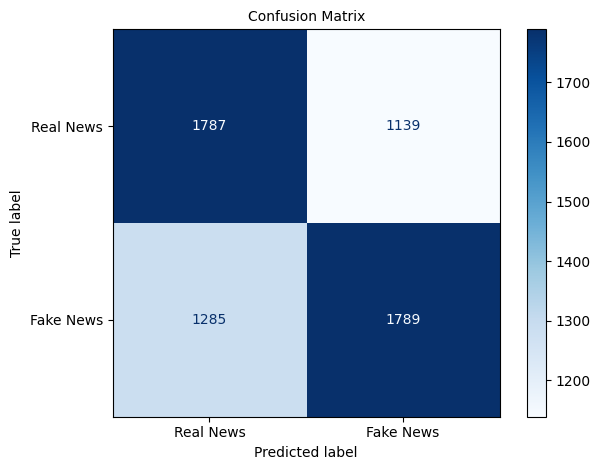

In [30]:
y_pred = model.predict(X_test_emb)

evaluate_model(y_test=y_test, y_pred=y_pred)